<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Modelisation_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelization - Neural network based on the extracted features

In this notebook we will teach the neural network based on the features we have extracted from the wikidata and wikipedia.
We will try a neural network model

In [1]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.models import Model
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_json('train_df_complete.json', orient="records", lines=True)
dev_df = pd.read_json('dev_df_complete.json', orient="records", lines=True)

Saving dev_df_complete.json to dev_df_complete.json
Saving train_df_complete.json to train_df_complete.json


### Reproducibility of experiments

tf random seed set so that the experiments with the neural netowrk are reproducible

In [2]:
SEED = 42
tf.random.set_seed(SEED)

### Data preparation for the neural network model

Here we adjust our dataframe in order to prepare it in the correct format for the neural network

In [3]:
# Get the list of explicatives variables
list_var = ['subclass_depth', 'subclasses', 'instances_of', 'instances_of_up', 'date', 'nb_lang',
       'descr_num_nouns', 'descr_num_verbs',
       'descr_num_adjectives', 'descr_has_location', 'descr_has_ethnic_group',
       'descr_has_event', 'type_cat', 'category_architecture',
       'category_biology', 'category_comics and anime', 'category_fashion',
       'category_films', 'category_food', 'category_geography',
       'category_literature', 'category_media', 'category_music',
       'category_politics', 'category_sports', 'category_transportation',
       'category_visual arts', 'category_combined',
       'main_country_cat'
]

# Create the X and y, train and dev
X_train = train_df[list_var]
y_train = train_df['label_int'].values

X_dev = dev_df[list_var]
y_dev = dev_df['label_int'].values

# Selecting numerical columns from X_train (all of them are int64 or float64)
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Defining pipeline: impute Nan, then scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Appling pipeline to numeric columns
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols)
])


#adjustin the data to proper format
X_train_processed = preprocessor.fit_transform(X_train)
X_dev_processed = preprocessor.transform(X_dev)

# float cast
X_train_processed = X_train_processed.astype('float32')
X_dev_processed = X_dev_processed.astype('float32')

# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_dev_cat = to_categorical(y_dev, num_classes=3)

# Neural network training -Hyperparameter tuning

  Firstly we try our network with the k-fold(k=5) cross validation in order to know how many epochs should we train our neural network not to underfit and not to overfit


In [4]:

# Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs_per_fold = []


for train_indices, val_indices in kfold.split(X_train_processed,y_train):


    X_train_fold, X_val_fold = X_train_processed[train_indices], X_train_processed[val_indices]
    y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]

    model_classification = models.Sequential()


    input_layer = layers.Input(shape=(29,), name="input_layer")

    model_classification.add(input_layer)



    for i, units in enumerate([1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]):
        dense_layer = layers.Dense(units, name=f"dense_layer_{i}")
        leaky_relu = LeakyReLU(alpha=0.1, name=f"leaky_relu_{i}")
        batch_norm = layers.BatchNormalization(name=f"batch_norm_{i}")
        dropout = layers.Dropout(0.3 if units > 128 else 0.2, name=f"dropout_{i}")


        model_classification.add(dense_layer)
        model_classification.add(leaky_relu)
        model_classification.add(batch_norm)
        model_classification.add(dropout)


    logits_output = layers.Dense(3, name="logits")
    model_classification.add(logits_output)
    softmax_output = layers.Activation('softmax', name="softmax")
    model_classification.add(softmax_output)




    model_classification.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])



    history = model_classification.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=200,
        batch_size=64,
        callbacks=[early_stop, reduce_lr]
    )
    epochs_per_fold.append(len(history.history['loss']))


print(f"mean num of epochs per fold is : {np.mean(epochs_per_fold)}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 177ms/step - accuracy: 0.4328 - loss: 1.3150 - val_accuracy: 0.5188 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5772 - loss: 0.9257 - val_accuracy: 0.4788 - val_loss: 0.9529 - learning_rate: 0.0010
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6359 - loss: 0.8237 - val_accuracy: 0.5084 - val_loss: 0.9184 - learning_rate: 0.0010
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6458 - loss: 0.7836 - val_accuracy: 0.6379 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6831 - loss: 0.7469 - val_accuracy: 0.6811 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 6/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6809 - loss: 0.7256 - val_accuracy: 0.7034 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 7/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6965 - loss: 0.6999 - va

## retraining on the whole data

now, knowing the proper number of epochs, we retrain the nn on the whole training data without the folds

In [5]:
import math

model_classification = models.Sequential()
model_logits= models.Sequential()


input_layer = layers.Input(shape=(29,), name="input_layer")

model_classification.add(input_layer)
model_logits.add(input_layer)



for i, units in enumerate([1024, 1024, 512, 512, 256, 256, 128, 128, 64, 64, 32, 32]):
    dense_layer = layers.Dense(units, name=f"dense_layer_{i}")
    leaky_relu = LeakyReLU(alpha=0.1, name=f"leaky_relu_{i}")
    batch_norm = layers.BatchNormalization(name=f"batch_norm_{i}")
    dropout = layers.Dropout(0.3 if units > 128 else 0.2, name=f"dropout_{i}")

    # Add the layers to both models
    model_classification.add(dense_layer)
    model_classification.add(leaky_relu)
    model_classification.add(batch_norm)
    model_classification.add(dropout)

    model_logits.add(dense_layer)
    model_logits.add(leaky_relu)
    model_logits.add(batch_norm)
    model_logits.add(dropout)


logits_output = layers.Dense(3, name="logits")
model_classification.add(logits_output)
model_logits.add(logits_output)
softmax_output = layers.Activation('softmax', name="softmax")
model_classification.add(softmax_output)



# Compilation
model_classification.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model_NN.summary()

history = model_classification.fit(
    X_train_processed, y_train_cat,
    epochs=math.floor(np.mean(epochs_per_fold)),
    batch_size=64,
)


logits_dev = model_logits.predict(X_dev_processed)
logits_train = model_logits.predict(X_train_processed)
np.save("dev_logits_description.npy", logits_dev)
np.save("train_logits_description.npy", logits_train)




Epoch 1/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.4191 - loss: 1.3588
Epoch 2/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6054 - loss: 0.8996
Epoch 3/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6400 - loss: 0.7888
Epoch 4/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6605 - loss: 0.7664
Epoch 5/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6870 - loss: 0.7322
Epoch 6/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6961 - loss: 0.7015
Epoch 7/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7123 - loss: 0.6862
Epoch 8/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7208 - loss: 0.6761
Epoch 9/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7261 - loss: 0.6604
Epoch 10/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7408 - loss: 0.6386
Epoch 11/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7410 - loss: 0.6377
Epoch 12/19
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7365 -

In [6]:
# Predictions on train
y_train_pred = model_classification.predict(X_train_processed)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

# Predictions on dev
y_dev_pred = model_classification.predict(X_dev_processed)
y_dev_pred_classes = np.argmax(y_dev_pred, axis=1)
y_dev_true_classes = np.argmax(y_dev_cat, axis=1)

# Accuracy
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes)
dev_accuracy = accuracy_score(y_dev_true_classes, y_dev_pred_classes)

print(f"Train accuracy : {train_accuracy * 100:.2f}%")
print(f"Dev accuracy   : {dev_accuracy * 100:.2f}%")


196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Train accuracy : 77.00%
Dev accuracy   : 74.00%


In [7]:
model_logits.save("model_logits_features.keras")

## Different approaches
we do not limit ourselves to deep learning approach with NN, but also try the more lightweight approaches from the classical ml such as: Random Forest, Logistic Regression, XGBoost, SVM and asses the outcomes by evaluating on the dev set and visualizin the outcomes with confusion matrices

### Random Forest

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Random Forest model, and training
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
model_RF.fit(X_train_processed, y_train_int)

# Predictions
y_train_pred = model_RF.predict(X_train_processed)
y_dev_pred = model_RF.predict(X_dev_processed)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)

print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")


Accuracy on Train: 99.70%
Accuracy on Dev: 75.00%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        76
           1       0.69      0.61      0.65       107
           2       0.84      0.89      0.86       117

    accuracy                           0.75       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.75      0.75      0.75       300



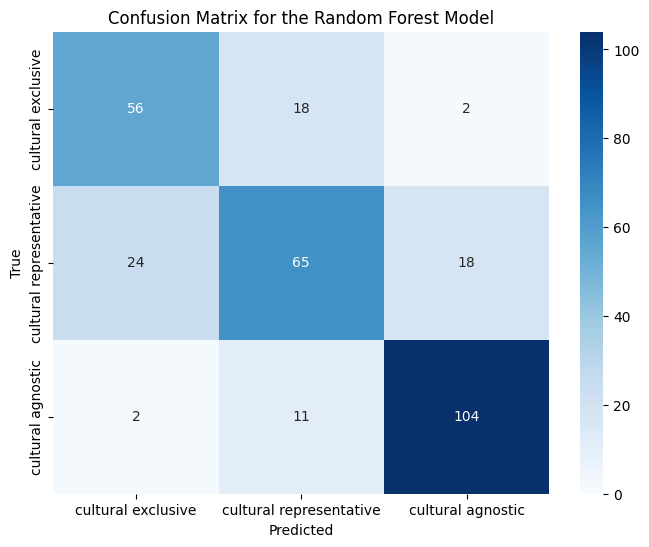

In [ ]:
# Confusion Matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for the Random Forest Model")
plt.show()


### XGBoost

In [ ]:
# Define XGBoost model
model_XG = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train model
model_XG.fit(X_train_processed, y_train)

# Predictions
y_train_pred = model_XG.predict(X_train_processed)
y_dev_pred = model_XG.predict(X_dev_processed)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
dev_accuracy = accuracy_score(y_dev, y_dev_pred)

print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:10:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy on Train: 90.91%
Accuracy on Dev: 72.33%


In [ ]:
# Classification report
print(classification_report(y_dev, y_dev_pred))

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        76
           1       0.65      0.61      0.63       107
           2       0.81      0.87      0.84       117

    accuracy                           0.72       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.72      0.72      0.72       300



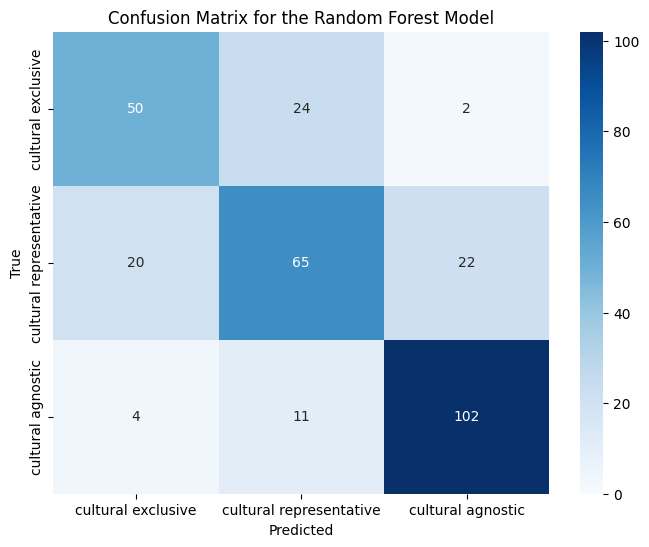

In [ ]:
# Confusion Matrix
cm_NN = confusion_matrix(y_dev, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for the Random Forest Model")
plt.show()


### SVM

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Model SVM and training
model_SV = SVC(kernel='rbf', probability=True)
model_SV.fit(X_train_processed, y_train_int)

# Predictions
y_train_pred = model_SV.predict(X_train_processed)
y_dev_pred = model_SV.predict(X_dev_processed)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)

print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")

Accuracy on Train: 77.75%
Accuracy on Dev: 74.00%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70        76
           1       0.73      0.53      0.62       107
           2       0.79      0.94      0.86       117

    accuracy                           0.74       300
   macro avg       0.73      0.73      0.72       300
weighted avg       0.74      0.74      0.73       300



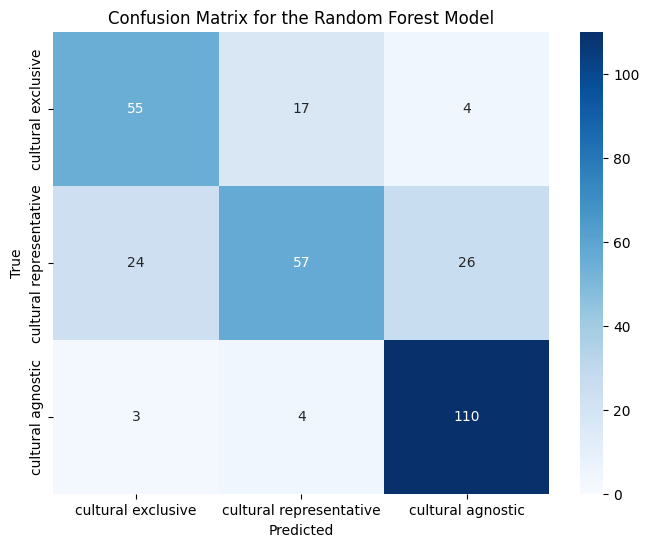

In [ ]:
# Confusion Matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for the Random Forest Model")
plt.show()


### Logistic Regression

In [ ]:
# From one hot to labels
y_train_int = np.argmax(y_train_cat, axis=1)
y_dev_int = np.argmax(y_dev_cat, axis=1)

# Model : Logistic regression. Training
model_LR = LogisticRegression(multi_class='multinomial', max_iter=1000)
model_LR.fit(X_train_processed, y_train_int)

# Prediction
y_train_pred = model_LR.predict(X_train_processed)
y_dev_pred = model_LR.predict(X_dev_processed)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_int, y_train_pred)
dev_accuracy = accuracy_score(y_dev_int, y_dev_pred)

print(f"Accuracy on Train: {train_accuracy * 100:.2f}%")
print(f"Accuracy on Dev: {dev_accuracy * 100:.2f}%")

Accuracy on Train: 75.04%
Accuracy on Dev: 76.33%


In [ ]:
# Classification report
print(classification_report(y_dev_int, y_dev_pred))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72        76
           1       0.78      0.58      0.67       107
           2       0.79      0.95      0.86       117

    accuracy                           0.76       300
   macro avg       0.76      0.75      0.75       300
weighted avg       0.76      0.76      0.76       300



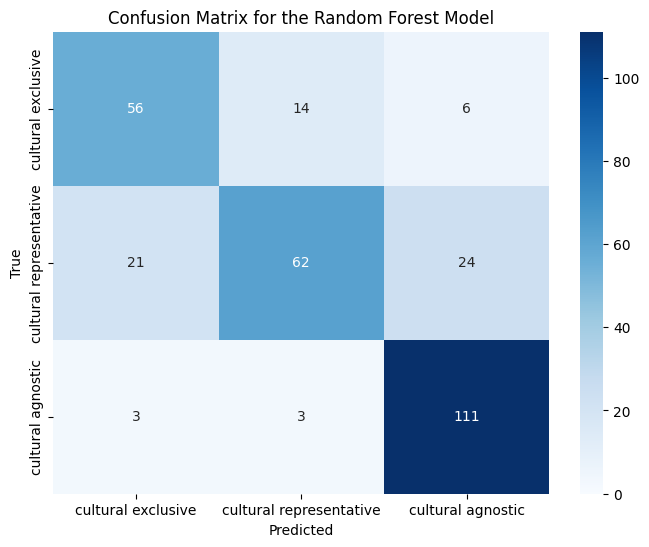

In [ ]:
# Confusion Matrix
cm_NN = confusion_matrix(y_dev_int, y_dev_pred)
plt.figure(figsize=(8,6))
classes = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", vmin=0, xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for the Random Forest Model")
plt.show()

# Exportation of the ML models

In [ ]:
# Save the model
#model_NN.save('model_NN.keras')
#model_RF.save('model_RF.keras')
#model_SV.save('model_SV.keras')
#model_XG.save('model_XG.keras')
#model_LR.save('model_LR.keras')